In [81]:
import sys
sys.path.append('..')
import theano.tensor as T
import theano
import numpy
import theano_lstm
import numpy as np
import data_managers
import os

# Plotting
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

In [2]:
net = theano_lstm.lstm_rnn( 300, [(128,128)], 150, save_weights_every=50000)

//anaconda/lib/python2.7/site-packages/theano/scan_module/scan_perform_ext.py:133: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility
  from scan_perform.scan_perform import *


In [76]:
%%time
net.initialize_training_adam()

CPU times: user 1min 35s, sys: 1.63 s, total: 1min 37s
Wall time: 1min 39s


In [82]:
params = net.LSTM_stack.list_params() + net.soft_reader.list_params()

In [85]:
def reset_params(params):
    for p in params:
        curr_val = p.get_value()
        if curr_val.shape[1] > 1:
            new_val = np.random.uniform(
                low=-1. / np.sqrt(curr_val.shape[1]),
                high=1. / np.sqrt(curr_val.shape[1]),
                size=curr_val.shape ).astype(theano.config.floatX)
            p.set_value(new_val)
        else:
            p.set_value( np.zeros(shape=curr_val.shape).astype(theano.config.floatX) )

In [4]:
# reload(data_managers)
data_butler = data_managers.character_data_manager('/Users/alex/Desktop/data manager/',
                                                   batch_size=1,minmax_doc_length=[0,300])

In [65]:
data_butler.advance_schedule()

In [66]:
q = data_butler.get_current_queries()
d = data_butler.get_current_doc()

In [67]:
q[0]['text']

u'QUERYSTART Although XXXXXX has had a number of lovers, it seems that none of them has touched her deeply or established a long-term alliance with her.'

In [68]:
q[0]['a']

1

In [117]:
d[0]['tags'][0:100]

[(0, None),
 None,
 None,
 None,
 None,
 (1, 1),
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 (1, 2),
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 (1, 1),
 None,
 None,
 None,
 (0, None),
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [229]:
reset_params( params )

In [230]:
def smooth_rep(data,sigma):
    w = np.ceil(2*sigma)
    f = np.exp( -.5*(np.arange(-w,w)**2)/(sigma**2) )
    f = f / np.sum(f)

    y = np.convolve(data,f,'valid')
    x = np.arange(w,len(data)-w+1)
    return x, y

In [235]:
data_butler.set_batch_size(1)

def multi_perms(n):
    v,l,a = data_butler.offer_data()
    if n > 1:
        for i in range(1,n):
            new_v, new_l, new_a = data_butler.permute_examples()#offer_data()
            v = np.dstack( (v, new_v) )
            l += new_l
            a = np.hstack( (a, new_a) )
    return 17.32*v, l, a

In [236]:
# Initialize cost 
cost = []

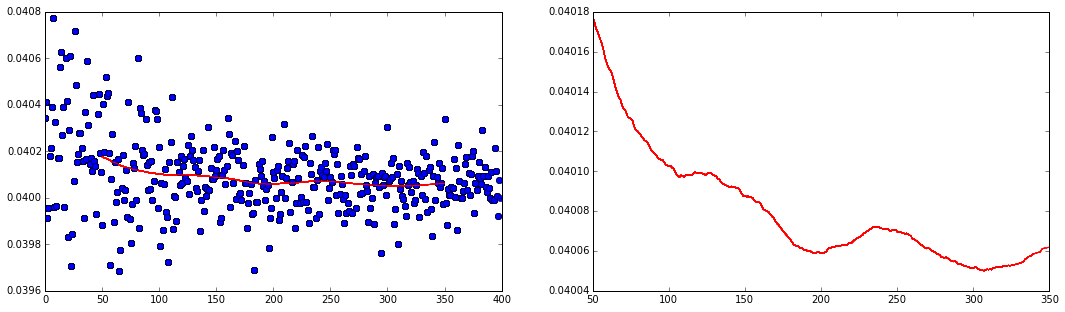

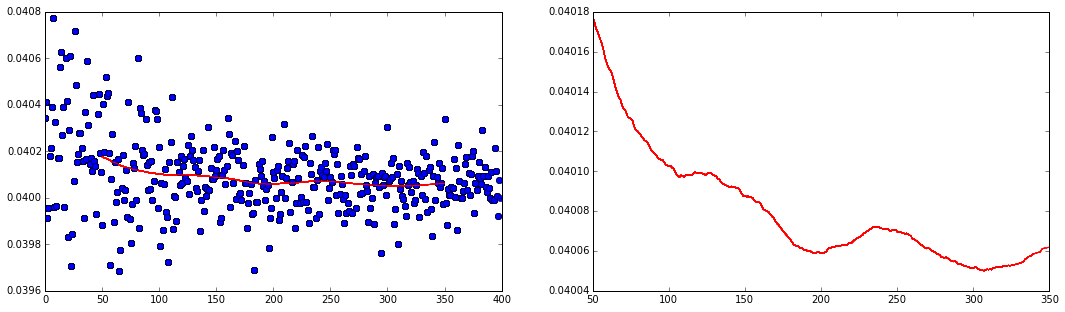

In [238]:
#Create plot 
fig = plt.figure(figsize=(18,5))
axB = fig.add_subplot(121)
axS = fig.add_subplot(122)
fig.subplots_adjust(wspace=.2)

start_plot_at = 0
smooth_sigma = 25

for batch in range(200):
    
    # Get the permuted data
    vectors, lengths, answer = multi_perms(25/data_butler.get_batch_size())
    
    # Step 
    temp_cost = net.adam_step(vectors, lengths, answer)
    cost.append(temp_cost)
    
    # Update plot
    C = np.array(cost[start_plot_at:])
    x, y = smooth_rep( C, smooth_sigma )
    if len(x) == len(y):
        axB.plot( np.arange(start_plot_at,len(cost)), C, 'bo', x+start_plot_at, y, 'r')
        axS.plot( x+start_plot_at, y, 'r')
    else:
        axB.plot( np.arange(start_plot_at,len(cost)), C, 'bo' )
    display.clear_output(wait=True)
    display.display(fig)